In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.privacy_techniques import (
                                        load_data, KAnonymizer, LDiversifier, 
                                        generalize_age, generalize_balance, generalize_categorical,
                                        compare_techniques, visualize_comparison, analyze_equivalence_classes
                                        )

## Load the bank marketing dataset

In [7]:
df = load_data("./data/bank.csv")

Dataset loaded successfully with 11162 rows and 17 columns


In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 1. K Anonimity and L Diversity

### Define privacy parameters

### Step 1: Define quasi-identifiers (attributes that could identify individuals)

In [8]:
quasi_identifiers = ['age', 'job', 'education', 'marital']

### Step 2: Define sensitive attributes (attributes we want to protect)

In [9]:
sensitive_attributes = ['balance', 'deposit']

### Step 3: Define generalization rules

In [10]:
# Age ranges for generalization
age_ranges = {
    "18-29": (18, 29),
    "30-39": (30, 39),
    "40-49": (40, 49),
    "50-59": (50, 59),
    "60+": (60, 100)
}

# Balance ranges for generalization
balance_ranges = {
    "Negative": (-10000, -1),
    "Low": (0, 999),
    "Medium": (1000, 4999),
    "High": (5000, 99999)
}

# Job categories for generalization
job_mappings = {
    "Office Worker": ["admin.", "management", "technician"],
    "Manual Labor": ["blue-collar", "services"],
    "Professional": ["entrepreneur", "self-employed"],
    "Other": ["unemployed", "housemaid", "student", "retired", "unknown"]
}

# Education categories for generalization
education_mappings = {
    "Basic": ["primary", "unknown"],
    "Intermediate": ["secondary"],
    "Advanced": ["tertiary"]
}

# Combine all generalization rules
generalization_rules = {
    "age": age_ranges,
    "balance": balance_ranges,
    "job": job_mappings,
    "education": education_mappings
}

### Step 4: Apply K-Anonymity

In [11]:
print("\nApplying K-Anonymity...")
k = 5  # Set the k value for k-anonymity
k_anonymizer = KAnonymizer(k=k)
k_anonymized_df_5 = k_anonymizer.fit_transform(df, quasi_identifiers, generalization_rules)

print(f"\nK-Anonymity (k={k}) applied successfully")
k_stats = k_anonymizer.get_stats()
print(f"Original records: {k_stats['original_records']}")
print(f"Records after {k}-anonymization: {k_stats['remaining_records']}")
print(f"Records suppressed: {k_stats['suppressed_records']}")
print(f"Suppression rate: {k_stats['suppression_rate']}%")
print(f"Average re-identification risk: {k_stats['avg_reidentification_risk']}")
print(f"Theoretical maximum re-identification probability: {k_stats['max_reidentification_probability']}")


Applying K-Anonymity...
Suppressing 63 records to satisfy 5-anonymity

K-Anonymity (k=5) applied successfully
Original records: 11162
Records after 5-anonymization: 11099
Records suppressed: 63
Suppression rate: 0.56%
Average re-identification risk: 0.011983
Theoretical maximum re-identification probability: 0.2


### K-Anonymity Evaluation Across Multiple k-values

In [12]:
k_values = [2, 3, 4, 5, 7, 9, 10]
results = {
    "k": [],
    "suppression_rate": [],
    "avg_reidentification_risk": [],
    "max_reidentification_probability": []
}

for k in k_values:
    print(f"\nApplying K-Anonymity for k = {k}...")
    k_anonymizer = KAnonymizer(k=k)
    k_anonymized_df = k_anonymizer.fit_transform(df, quasi_identifiers, generalization_rules)
    
    k_stats = k_anonymizer.get_stats()
    
    results["k"].append(k)
    results["suppression_rate"].append(k_stats["suppression_rate"])
    results["avg_reidentification_risk"].append(k_stats["avg_reidentification_risk"])
    results["max_reidentification_probability"].append(k_stats["max_reidentification_probability"])
    
    print(f"K={k} | Suppression Rate: {k_stats['suppression_rate']}% | Avg Risk: {k_stats['avg_reidentification_risk']} | Max Risk: {k_stats['max_reidentification_probability']}")


Applying K-Anonymity for k = 2...
Suppressing 10 records to satisfy 2-anonymity
K=2 | Suppression Rate: 0.09% | Avg Risk: 0.01363 | Max Risk: 0.5

Applying K-Anonymity for k = 3...
Suppressing 28 records to satisfy 3-anonymity
K=3 | Suppression Rate: 0.25% | Avg Risk: 0.012844 | Max Risk: 0.333333

Applying K-Anonymity for k = 4...
Suppressing 43 records to satisfy 4-anonymity
K=4 | Suppression Rate: 0.39% | Avg Risk: 0.012411 | Max Risk: 0.25

Applying K-Anonymity for k = 5...
Suppressing 63 records to satisfy 5-anonymity
K=5 | Suppression Rate: 0.56% | Avg Risk: 0.011983 | Max Risk: 0.2

Applying K-Anonymity for k = 7...
Suppressing 128 records to satisfy 7-anonymity
K=7 | Suppression Rate: 1.15% | Avg Risk: 0.010966 | Max Risk: 0.142857

Applying K-Anonymity for k = 9...
Suppressing 164 records to satisfy 9-anonymity
K=9 | Suppression Rate: 1.47% | Avg Risk: 0.010547 | Max Risk: 0.111111

Applying K-Anonymity for k = 10...
Suppressing 182 records to satisfy 10-anonymity
K=10 | Supp

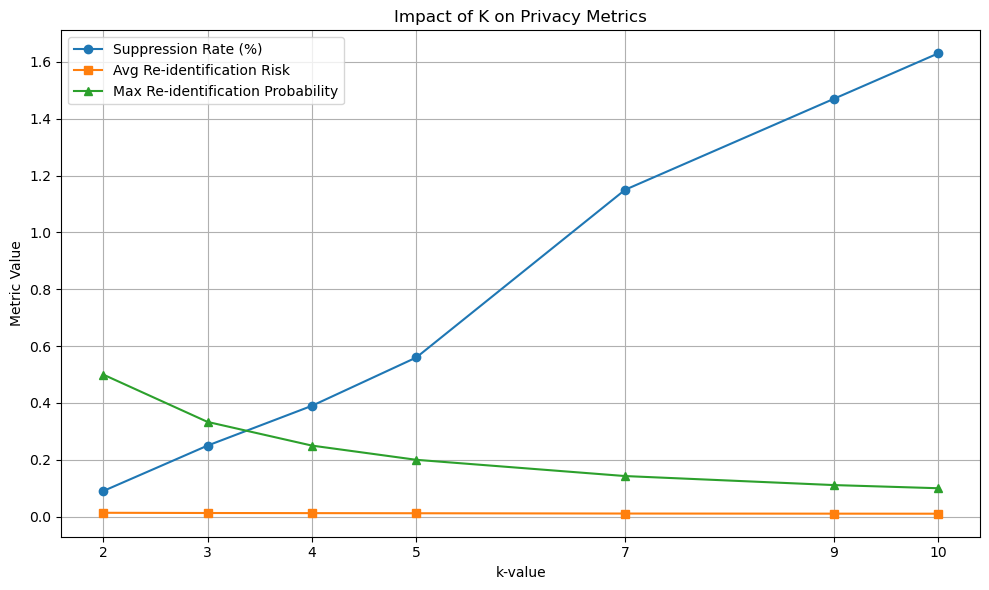

In [13]:
# ---------- Plotting ---------- #
plt.figure(figsize=(10, 6))
plt.plot(results["k"], results["suppression_rate"], marker='o', label="Suppression Rate (%)")
plt.plot(results["k"], results["avg_reidentification_risk"], marker='s', label="Avg Re-identification Risk")
plt.plot(results["k"], results["max_reidentification_probability"], marker='^', label="Max Re-identification Probability")

plt.title("Impact of K on Privacy Metrics")
plt.xlabel("k-value")
plt.ylabel("Metric Value")
plt.xticks(results["k"])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Step 5: Apply L-Diversity on top of K-anonymized data with k = 5

In [14]:
def print_sensitive_distribution_comparison(df, quasi_cols, sensitive_cols, top_n_groups=5):
    global_distributions = {col: df[col].value_counts(normalize=True) for col in sensitive_cols}
    grouped = df.groupby(quasi_cols)

    print("\n🔍 GLOBAL DISTRIBUTIONS:")
    for col in sensitive_cols:
        print(f"\n{col}:")
        print(global_distributions[col].round(3))

    print("\n📦 TOP EQUIVALENCE CLASSES COMPARISON:")
    for i, (name, group) in enumerate(grouped):
        if i >= top_n_groups:
            break
        print(f"\nGroup {i+1} (Size={len(group)}) - QI values: {name}")
        for col in sensitive_cols:
            local_dist = group[col].value_counts(normalize=True).round(3)
            print(f"  {col}:")
            print(f"    {local_dist.to_dict()}")
def plot_sensitive_distributions(df, quasi_cols, sensitive_cols, top_n_groups=5):
    grouped = df.groupby(quasi_cols)
    group_list = list(grouped)

    for col in sensitive_cols:
        fig, ax = plt.subplots(figsize=(10, 5))
        global_dist = df[col].value_counts(normalize=True)
        df_plot = pd.DataFrame(global_dist).T
        df_plot.index = ['Global']

        for i, (name, group) in enumerate(group_list[:top_n_groups]):
            local_dist = group[col].value_counts(normalize=True)
            local_df = pd.DataFrame(local_dist).T
            local_df.index = [f"Group {i+1}"]
            df_plot = pd.concat([df_plot, local_df])

        df_plot.fillna(0, inplace=True)
        df_plot.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
        plt.title(f"Distribution of '{col}' Across Global and Top {top_n_groups} Equivalence Classes")
        plt.ylabel("Proportion")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
# Age ranges for generalization
age_ranges = {
    "18-29": (18, 29),
    "30-39": (30, 39),
    "40-49": (40, 49),
    "50-59": (50, 59),
    "60+": (60, 100)
}

# Balance ranges for generalization
balance_ranges = {
    "Negative": (-10000, -1),
    "Low": (0, 999),
    "Medium": (1000, 4999),
    "High": (5000, 99999)
}

# Job categories for generalization
job_mappings = {
    "Office Worker": ["admin.", "management", "technician"],
    "Manual Labor": ["blue-collar", "services"],
    "Professional": ["entrepreneur", "self-employed"],
    "Other": ["unemployed", "housemaid", "student", "retired", "unknown"]
}

# Education categories for generalization
education_mappings = {
    "Basic": ["primary", "unknown"],
    "Intermediate": ["secondary"],
    "Advanced": ["tertiary"]
}

# Combine all generalization rules
generalization_rules = {
    "age": age_ranges,
    "balance": balance_ranges,
    "job": job_mappings,
    "education": education_mappings
}

### For L = 2

In [15]:
print("\nApplying K-Anonymity...")
k = 5  # Set the k value for k-anonymity
k_anonymizer = KAnonymizer(k=k)
k_anonymized_df_5 = k_anonymizer.fit_transform(df, quasi_identifiers, generalization_rules)


Applying K-Anonymity...
Suppressing 63 records to satisfy 5-anonymity



Applying L-Diversity on K-anonymized data...
Suppressing 0 records to satisfy 2-diversity

L-Diversity (l=2) applied successfully on K-anonymized data

L-Diversity Statistics (l=2):
k_anonymized_records: 11099
remaining_records: 11099
additional_suppressed_records: 0
suppression_rate: 0.0
equivalence_class_count: 133
avg_equivalence_class_size: 83.45
generalized_columns: []
avg_reidentification_risk: 0.011983


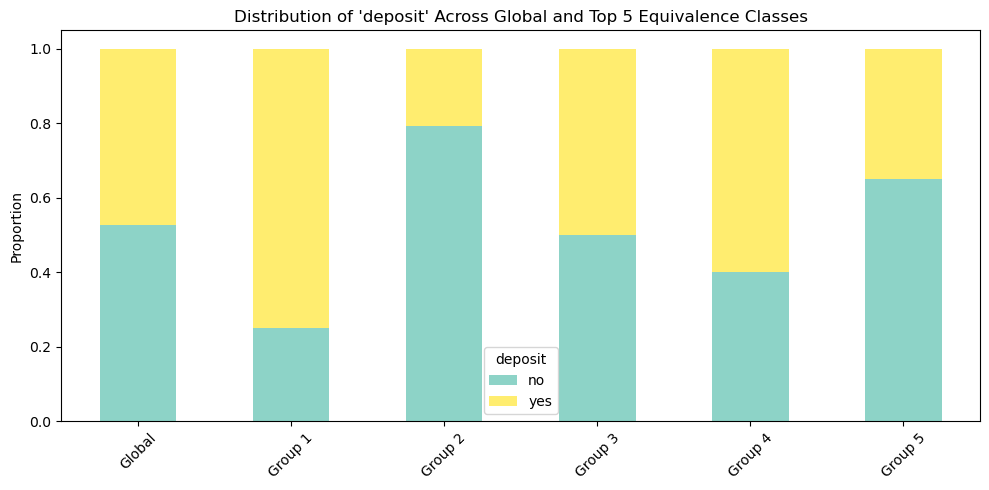

In [16]:
print("\nApplying L-Diversity on K-anonymized data...")
l = 2  # Set the l value for l-diversity
l_diversifier = LDiversifier(l=l)
sensitive_attributes = ['deposit']
l_diversified_df = l_diversifier.fit_transform(k_anonymized_df_5, quasi_identifiers, sensitive_attributes)

print(f"\nL-Diversity (l={l}) applied successfully on K-anonymized data")
l_stats = l_diversifier.get_stats()
print(f"\nL-Diversity Statistics (l={l}):")
for key, value in l_stats.items():
    print(f"{key}: {value}")
plot_sensitive_distributions(l_diversified_df, quasi_identifiers, sensitive_attributes)


Applying L-Diversity on K-anonymized data...

L-Diversity (l=2) applied successfully on K-anonymized data

L-Diversity Statistics (l=2):
k_anonymized_records: 11099
remaining_records: 11099
additional_suppressed_records: 0
suppression_rate: 0.0
equivalence_class_count: 133
avg_equivalence_class_size: 83.45
generalized_columns: []
avg_reidentification_risk: 0.011983


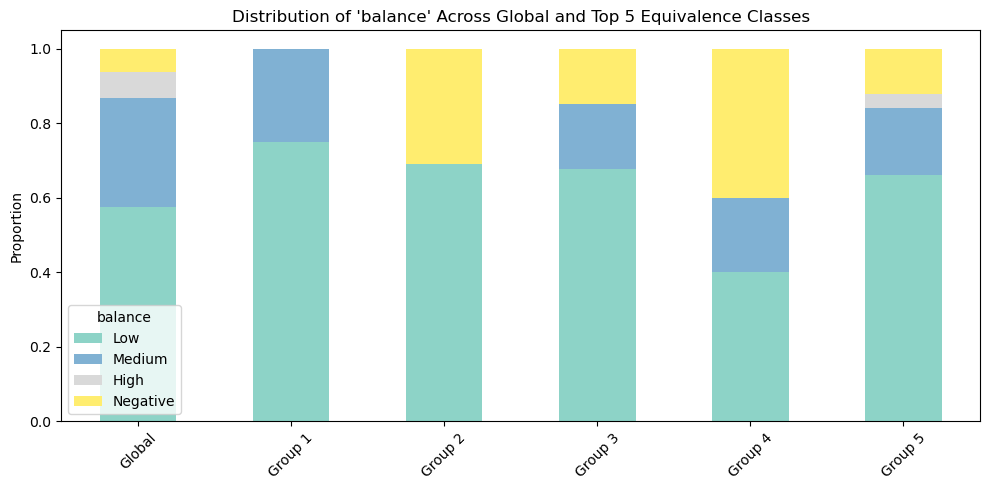

In [17]:
print("\nApplying L-Diversity on K-anonymized data...")
l = 2  # Set the l value for l-diversity
l_diversifier = LDiversifier(l=l)
sensitive_attributes = ['balance']
l_diversified_df = l_diversifier.fit_transform(k_anonymized_df_5, quasi_identifiers, sensitive_attributes)

print(f"\nL-Diversity (l={l}) applied successfully on K-anonymized data")
l_stats = l_diversifier.get_stats()
print(f"\nL-Diversity Statistics (l={l}):")
for key, value in l_stats.items():
    print(f"{key}: {value}")
plot_sensitive_distributions(l_diversified_df, quasi_identifiers, sensitive_attributes)

### For L = 3

### Refining the rules for L diversity

In [122]:
age_ranges = {
    "18-34": (18, 34),
    "35-49": (35, 49),
    "50-64": (50, 64),
    "65+": (65, 100)
}


# Balance ranges for generalization
balance_ranges = {
    "Negative": (-100000, -1),      # Include deeper negative balances
    "Low": (0, 999),
    "Medium": (1000, 9999),
    "High": (10000, 999999)
}


# Job categories for generalization
job_mappings = {
    "White Collar": ["admin.", "management", "technician", "entrepreneur", "self-employed"],
    "Blue Collar": ["blue-collar", "services", "housemaid"],
    "Non-Working": ["unemployed", "student", "retired"],
    "Unknown": ["unknown"]
}


# Education categories for generalization
education_mappings = {
    "Basic": ["primary", "secondary", "unknown"],
    "Advanced": ["tertiary"]
}


# Combine all generalization rules
generalization_rules = {
    "age": age_ranges,
    "balance": balance_ranges,
    "job": job_mappings,
    "education": education_mappings
}

In [123]:
print("\nApplying K-Anonymity...")
k = 5  # Set the k value for k-anonymity
k_anonymizer = KAnonymizer(k=k)
k_anonymized_df_5 = k_anonymizer.fit_transform(df, quasi_identifiers, generalization_rules)


Applying K-Anonymity...
Suppressing 49 records to satisfy 5-anonymity


In [124]:
print("\nApplying L-Diversity on K-anonymized data...")
l = 3  # Set the l value for l-diversity
l_diversifier = LDiversifier(l=l)
sensitive_attributes = ['balance']
l_diversified_df = l_diversifier.fit_transform(k_anonymized_df_5, quasi_identifiers, sensitive_attributes)

print(f"\nL-Diversity (l={l}) applied successfully on K-anonymized data")
l_stats = l_diversifier.get_stats()
print(f"\nL-Diversity Statistics (l={l}):")
for key, value in l_stats.items():
    print(f"{key}: {value}")


Applying L-Diversity on K-anonymized data...
Suppressing 0 records to satisfy 3-diversity

L-Diversity (l=3) applied successfully on K-anonymized data

L-Diversity Statistics (l=3):
k_anonymized_records: 11113
remaining_records: 11113
additional_suppressed_records: 0
suppression_rate: 0.0
equivalence_class_count: 59
avg_equivalence_class_size: 188.36
generalized_columns: []
avg_reidentification_risk: 0.005309


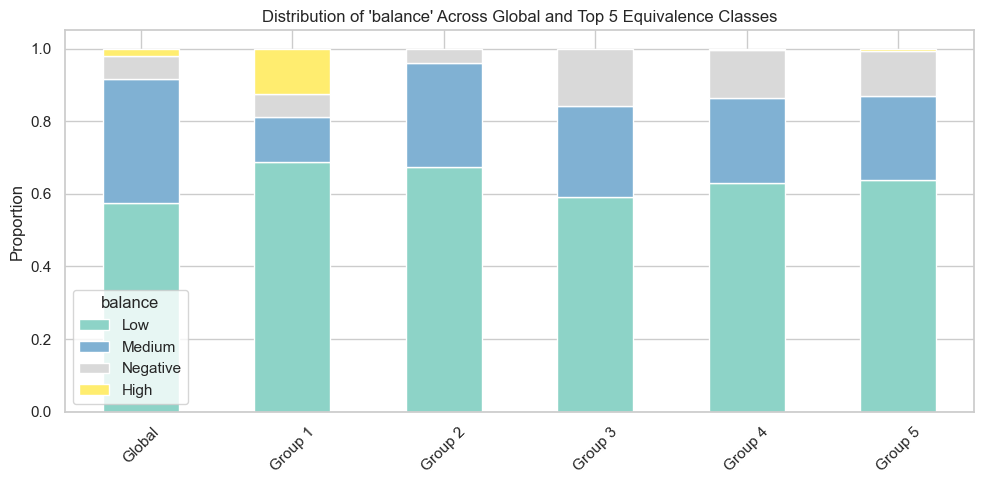

In [125]:
plot_sensitive_distributions(l_diversified_df, quasi_identifiers, sensitive_attributes)

## 2. Differential Privacy

In [3]:
# Import the class and functions
from scripts.differential_privacy import DifferentialPrivacy, load_data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
# Load the dataset
df = load_data("./data/bank.csv")

# Define attributes
quasi_identifiers = ['age', 'job', 'education', 'marital']
sensitive_attributes = ['balance', 'deposit']
numerical_cols = ['age', 'balance']

# Apply differential privacy
dp = DifferentialPrivacy(epsilon=1.0)
dp_anonymized = dp.fit_transform(df, quasi_identifiers, sensitive_attributes, numerical_cols)

# View stats
dp_stats = dp.get_stats()
dp_stats


Dataset loaded successfully with 11162 rows and 17 columns


{'epsilon': 1.0,
 'original_records': 11162,
 'remaining_records': 11162,
 'suppressed_records': 0,
 'suppression_rate': 0,
 'avg_info_loss': np.float64(4.430244097146033e-05),
 'noise_added': {'balance': {'mean': -0.015113598275974098,
   'std': 11.026849418413645,
   'min': -70.28832114534326,
   'max': 59.4134494442504,
   'scale': 7.888460849310159}},
 'reidentification_risk': np.float64(0.7310585786300049)}

Dataset loaded successfully with 11162 rows and 17 columns


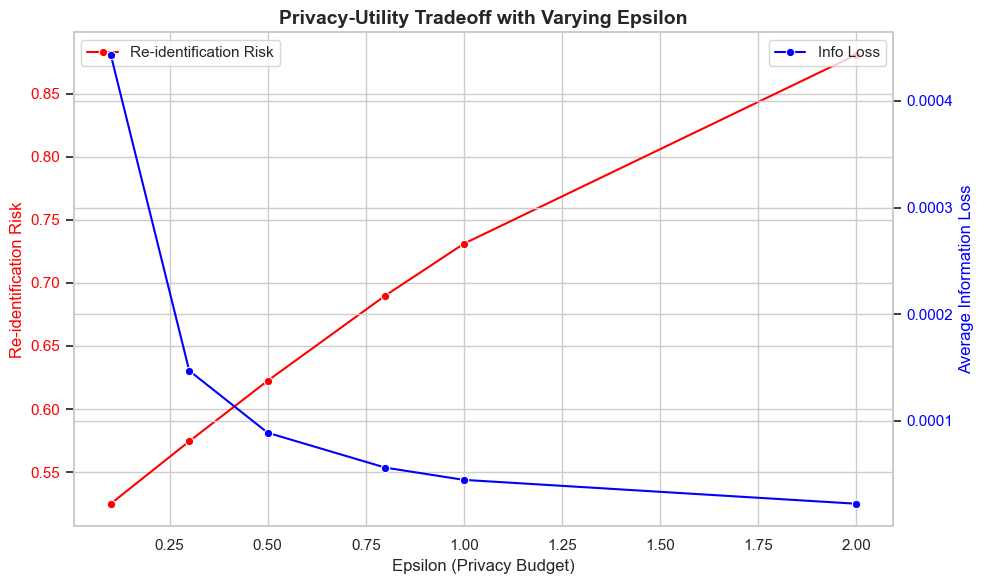

In [ ]:
# Load the dataset
df = load_data("./data/bank.csv")

# Define attributes
quasi_identifiers = ['age', 'job', 'education', 'marital']
sensitive_attributes = ['balance', 'deposit']
numerical_cols = ['age', 'balance']

# Define different epsilon values to test
epsilon_values = [0.1,0.3, 0.5,0.8, 1.0, 2.0]
risks = []
losses = []

# Run DP for each epsilon
for eps in epsilon_values:
    dp = DifferentialPrivacy(epsilon=eps)
    dp.fit_transform(df.copy(), quasi_identifiers, sensitive_attributes, numerical_cols)
    stats = dp.get_stats()
    
    risks.append(stats['reidentification_risk'])
    losses.append(stats['avg_info_loss'])

# Create a dataframe for plotting
result_df = pd.DataFrame({
    "Epsilon": epsilon_values,
    "Re-identification Risk": risks,
    "Average Info Loss": losses
})

# Plotting
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot re-identification risk
sns.lineplot(x="Epsilon", y="Re-identification Risk", data=result_df, marker="o", label="Re-identification Risk", ax=ax1, color="red")
ax1.set_ylabel("Re-identification Risk", fontsize=12, color='red')
ax1.set_xlabel("Epsilon (Privacy Budget)", fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')

# Plot info loss on secondary axis
ax2 = ax1.twinx()
sns.lineplot(x="Epsilon", y="Average Info Loss", data=result_df, marker="o", label="Info Loss", ax=ax2, color="blue")
ax2.set_ylabel("Average Information Loss", fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legend
plt.title("Privacy-Utility Tradeoff with Varying Epsilon", fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

In [67]:
df.deposit.value_counts(normalize=True)

deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64

In [68]:
dp_anonymized.deposit.value_counts(normalize=True)

deposit
no     0.513438
yes    0.486562
Name: proportion, dtype: float64

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Create datasets
df_full = df.copy()
df_removed = df.drop(df.sample(n=1, random_state=42).index)

# Step 2: Apply DP
dp1 = DifferentialPrivacy(epsilon=1.0)
anonymized_full = dp1.fit_transform(df_full, quasi_identifiers, sensitive_attributes, numerical_cols)

dp2 = DifferentialPrivacy(epsilon=1.0)
anonymized_removed = dp2.fit_transform(df_removed, quasi_identifiers, sensitive_attributes, numerical_cols)

In [76]:
anonymized_full.balance.describe()

count    11162.000000
mean      1528.797795
std       3225.383601
min      -6847.529318
25%        122.834269
50%        550.004378
75%       1709.158312
max      81204.053468
Name: balance, dtype: float64

In [79]:
anonymized_removed.balance.describe()

count    11161.000000
mean      1528.343834
std       3225.663285
min      -6854.497424
25%        120.922263
50%        549.851513
75%       1709.488177
max      81202.412401
Name: balance, dtype: float64

In [80]:
anonymized_full.deposit.describe()

count     11162
unique        2
top          no
freq       5642
Name: deposit, dtype: object

In [81]:
anonymized_removed.deposit.describe()

count     11161
unique        2
top         yes
freq       5597
Name: deposit, dtype: object

In [83]:
raw_full = df.copy()
raw_removed = df.drop(df.sample(n=1, random_state=42).index)

In [84]:
raw_full.balance.describe()

count    11162.000000
mean      1528.538524
std       3225.413326
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [85]:
raw_removed.balance.describe()

count    11161.000000
mean      1528.608816
std       3225.549280
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [91]:
raw_full.deposit.value_counts(normalize=True)

deposit
no     0.52616
yes    0.47384
Name: proportion, dtype: float64

In [92]:
raw_removed.deposit.value_counts(normalize=True)

deposit
no     0.526118
yes    0.473882
Name: proportion, dtype: float64